In [159]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [327]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import csv

import sys
sys.path.append('../src')

from display_network import display_graph_pyvis
from make_belief_network import networkx_graph_from_vars_adj_mat
from graph_tools import make_consistent_matrix

In [328]:
def merge_sorted_lists(list1, list2):

    def safe_index(lst, i):
        if (i >= 0 and i < len(lst)) or (i < 0 and i >= -len(lst)):
            return lst[i].lower()
        else:
            return chr(1114111)
    
    # Initialize pointers for both lists
    i, j = 0, 0
    merged_list = []
    list1_inds = []
    list2_inds = []
    
    curr_ind = -1
    # Traverse both lists and insert smaller value from either list into the merged list
    while i < len(list1) or j < len(list2):

        # print(merged_list)
        # print("1", safe_index(list1, i), i)
        # print("2", safe_index(list2, j), j)
        
        # never repeat an entry
        # you're only ever at risk of doing this if the last entry is the same as your current one
        if safe_index(list1, i) == safe_index(merged_list, -1):
            # print("1 repeat")
            list1_inds.append(curr_ind)
            i += 1
        elif safe_index(list2, j) == safe_index(merged_list, -1):
            # print("2 repeat")
            list2_inds.append(curr_ind)
            j += 1
        elif safe_index(list1, i) < safe_index(list2, j):
            # print("1 add")
            curr_ind += 1
            list1_inds.append(curr_ind)
            merged_list.append(list1[i])
            i += 1
        else:
            curr_ind += 1
            list2_inds.append(curr_ind)
            merged_list.append(list2[j])
            # print("2 add")
            j += 1

    return merged_list, list1_inds, list2_inds

def combine_variable_matrix_stacks(var_list_1, var_list_2, var_mat_1, var_mat_2):
    var_list, l1_indices, l2_indices = merge_sorted_lists(var_list_1, var_list_2)
    
    def make_super_matrix_stack(old_mat, submat_indices, new_size):
        new_matrix_stack = np.full((old_mat.shape[0], new_size, new_size), np.nan)
        dim1 = np.ix_(submat_indices, submat_indices)[0]
        dim2 = np.ix_(submat_indices, submat_indices)[1]
        new_matrix_stack[:, dim1, dim2] = old_mat

        return new_matrix_stack

    new_var_mat_1 = make_super_matrix_stack(var_mat_1, l1_indices, len(var_list))
    new_var_mat_2 = make_super_matrix_stack(var_mat_2, l2_indices, len(var_list))

    new_var_mat = np.concatenate((new_var_mat_1, new_var_mat_2), axis=0)

    return var_list, new_var_mat

def csv_to_sorted_list(path):
    # Initialize an empty list to store the strings
    lines = []

    # Open the CSV file and read it
    with open(path, mode='r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Join the row into a single string separated by commas
            line = ','.join(row)
            lines.append(line)
    
    indexed_list = list(enumerate(lines))
    sorted_indexed_list = sorted(indexed_list, key=lambda x: x[1]) # sort based on the value
    index_list = [ind for ind, val in sorted_indexed_list]
    value_list = [val for ind, val in sorted_indexed_list]

    return index_list, value_list

def make_edge_time_series_from_graph(start_year, end_year, interval, overlap, node1, node2):
    curr_year = start_year
    edge_weights = []
    years = []
    while curr_year + interval <= end_year:
        path = f"../out/belief networks/{curr_year}-{curr_year + interval}, R=0.2, Condition=None"
        G = nx.read_graphml(os.path.join(path, "graph_object.graphml"))
        var_list = csv_to_list(os.path.join(path, "variables_list.csv"))
        
        if node1 in G and node2 in G:
            edge_data = G.get_edge_data(node1, node2)

            if edge_data is None:
                edge_val = 0
            else:
                edge_val = edge_data.get('weight')
        else:
            edge_val = None

        years.append(curr_year)
        edge_weights.append(edge_val)
        curr_year = curr_year + interval - overlap
  

    return edge_weights, years

def get_sorted_adj_mat_and_var_list(path):
    ind_list, var_list = csv_to_sorted_list(os.path.join(path, "variables_list.csv"))
    l = len(var_list)
    adj_mat = np.genfromtxt(os.path.join(path, "correlation_matrix_partial.csv"), delimiter=',')
    adj_mat = adj_mat[ind_list, :][:, ind_list] - np.identity(l)
    
    return adj_mat, var_list

def make_edge_time_series(start_year, end_year, interval, overlap):
    curr_year = start_year
    years = []
    while curr_year + interval <= end_year:
        path = f"../out/belief networks/{curr_year}-{curr_year + interval}, R=0.2, Condition=None"
        print(path)

        new_data, new_var_list = get_sorted_adj_mat_and_var_list(path)
        new_data = new_data.reshape(1, len(new_var_list), len(new_var_list))

        if start_year != curr_year:
            curr_var_list, curr_data = combine_variable_matrix_stacks(curr_var_list, new_var_list, curr_data, new_data)
        else:
            curr_var_list = new_var_list
            curr_data = new_data

        years.append(curr_year)
        curr_year = curr_year + interval - overlap
  

    return curr_var_list, curr_data, years

def merge_graphs_with_weight_diff(before_graph, after_graph, pct_change=False):
    # Create a new empty graph
    merged_graph = nx.Graph()

    # Add nodes from both graphs to the new graph
    merged_graph.add_nodes_from(before_graph.nodes())
    merged_graph.add_nodes_from(after_graph.nodes())

    # Get the union of edges from both graphs
    all_edges = set(before_graph.edges()).union(set(after_graph.edges()))

    # Add edges with the sum of weights
    for edge in all_edges:
        # Get the weight of the edge in graph1 (0 if the edge doesn't exist)
        
        before_weight = before_graph[edge[0]].get(edge[1], {}).get('weight', 0) if edge[0] in before_graph and edge[1] in before_graph else 0
        
        # Get the weight of the edge in graph2 (0 if the edge doesn't exist)
        after_weight = after_graph[edge[0]].get(edge[1], {}).get('weight', 0) if edge[0] in after_graph and edge[1] in after_graph else 0
        
        # Add the edge with the summed weight to the new graph
        change = (after_weight - before_weight)/((before_weight + after_weight)/2) if pct_change else after_weight - before_weight
        merged_graph.add_edge(edge[0], edge[1], weight=after_weight, type=change)

    return merged_graph

def make_change_graph(adj_var_list, adj_mat, change_var_list, change_mat):
    new_change_mat = make_consistent_matrix(adj_var_list, change_var_list, change_mat)
    num_nodes = adj_mat.shape[0]

    G = nx.Graph()
    G.add_nodes_from(adj_var_list)

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if adj_mat[i, j] != 0 or ~np.isnan(new_change_mat[i, j]):
                weight = max(1e-5, adj_mat[i, j])
                change = 0 if np.isnan(new_change_mat[i, j]) else new_change_mat[i, j]

                G.add_edge(adj_var_list[i], adj_var_list[j], weight=weight, type=change)
    
    return G

def calc_sd_change_from_window_mean(matrix_stack, window, start_at=None, reqd_samples=None):
    start_row = window if start_at is None else start_at
    reqd_samples = window if reqd_samples is None else reqd_samples
    change_mat = np.full(matrix_stack.shape, np.nan)
    
    for curr_row in range(start_row, matrix_stack.shape[0]):
        window_start = max(0, curr_row - window)
        relevant_substack = matrix_stack[window_start:curr_row, :, :]
        sufficient_samples = np.sum(~np.isnan(relevant_substack), axis=0) >= reqd_samples

        window_mean = np.where(sufficient_samples, np.nanmean(relevant_substack, axis=0), np.nan)
        window_sdev = np.where(sufficient_samples, np.nanstd(relevant_substack, axis=0), np.nan)
        denominator = np.where(window_sdev != 0, window_sdev, np.nan)
        change_mat[curr_row, :, :] = (matrix_stack[curr_row, :, :] - window_mean) / denominator

    return change_mat

In [164]:
vars_1 = csv_to_list("../out/belief networks/1972-1976, R=0.2, Condition=None/variables_list.csv")
vars_2 = csv_to_list("../out/belief networks/1974-1978, R=0.2, Condition=None/variables_list.csv")

var_mat_1 = np.genfromtxt("../out/belief networks/1972-1976, R=0.2, Condition=None/correlation_matrix_partial.csv", delimiter=',').reshape(1, len(vars_1), len(vars_1))
var_mat_2 = np.genfromtxt("../out/belief networks/1974-1978, R=0.2, Condition=None/correlation_matrix_partial.csv", delimiter=',').reshape(1, len(vars_2), len(vars_2))

var_list, var_mat = combine_variable_matrix_stacks(vars_1, vars_2, var_mat_1, var_mat_2)


In [174]:
curr_year = 1980
interval = 4
path = f"../out/belief networks/{curr_year}-{curr_year + interval}, R=0.2, Condition=None"

G = nx.read_graphml(os.path.join(path, "graph_object.graphml"))
adj_mat, var_list = get_sorted_adj_mat_and_var_list(path)

print(var_list)
node1 = "CONBUS"
node2 = "CONARMY"

print(G.get_edge_data(node1, node2))
node1_ind = var_list.index(node1)
node2_ind = var_list.index(node2)
print(adj_mat[node2_ind, node1_ind])

['ABANY', 'ABDEFECT', 'ABHLTH', 'ABNOMORE', 'ABPOOR', 'ABRAPE', 'ABSINGLE', 'ATTEND', 'CAPPUN', 'COLATH', 'COLCOM', 'COLHOMO', 'COLMIL', 'COLRAC', 'CONARMY', 'CONBUS', 'CONCLERG', 'CONEDUC', 'CONFED', 'CONFINAN', 'CONJUDGE', 'CONLABOR', 'CONLEGIS', 'CONMEDIC', 'CONPRESS', 'CONSCI', 'CONTV', 'COURTS', 'DIVLAW', 'EQWLTH', 'FAIR', 'FEPOL', 'GETAHEAD', 'GRASS', 'GUNLAW', 'HELPFUL', 'HOMOSEX', 'LETDIE1', 'LIBATH', 'LIBCOM', 'LIBHOMO', 'LIBMIL', 'LIBRAC', 'NATAID', 'NATARMS', 'NATCITY', 'NATCRIME', 'NATDRUG', 'NATEDUC', 'NATENVIR', 'NATFARE', 'NATHEAL', 'NATRACE', 'NATSPAC', 'NEWS', 'PARTYID', 'POLABUSE', 'POLATTAK', 'POLESCAP', 'POLHITOK', 'POLMURDR', 'POLVIEWS', 'PORNLAW', 'POSTLIFE', 'PRAYER', 'PREMARSX', 'PRESLAST_DEMREP', 'PRESLAST_NONCONFORM', 'RELITEN', 'SEXEDUC', 'SPKATH', 'SPKCOM', 'SPKHOMO', 'SPKMIL', 'SPKRAC', 'SUICIDE1', 'SUICIDE2', 'TRUST', 'TVHOURS', 'VOTELAST', 'XMARSEX']
None
0.0


In [329]:
comp_var_list, comp_data, years = make_edge_time_series(1972, 2020, 4, 2)
change_data = calc_sd_change_from_window_mean(comp_data, 6, start_at=3, reqd_samples=3)

avgs = np.nanmean(np.abs(comp_data), axis=0)
nonzero_entries = np.where(avgs > 1e-3)

lines_to_draw = np.random.randint(0, len(nonzero_entries[0]), size=(1000,))
coordinates_to_draw = (nonzero_entries[0][lines_to_draw], nonzero_entries[1][lines_to_draw])

../out/belief networks/1972-1976, R=0.2, Condition=None
../out/belief networks/1974-1978, R=0.2, Condition=None
../out/belief networks/1976-1980, R=0.2, Condition=None
../out/belief networks/1978-1982, R=0.2, Condition=None
../out/belief networks/1980-1984, R=0.2, Condition=None
../out/belief networks/1982-1986, R=0.2, Condition=None
../out/belief networks/1984-1988, R=0.2, Condition=None
../out/belief networks/1986-1990, R=0.2, Condition=None
../out/belief networks/1988-1992, R=0.2, Condition=None
../out/belief networks/1990-1994, R=0.2, Condition=None
../out/belief networks/1992-1996, R=0.2, Condition=None
../out/belief networks/1994-1998, R=0.2, Condition=None
../out/belief networks/1996-2000, R=0.2, Condition=None
../out/belief networks/1998-2002, R=0.2, Condition=None
../out/belief networks/2000-2004, R=0.2, Condition=None
../out/belief networks/2002-2006, R=0.2, Condition=None
../out/belief networks/2004-2008, R=0.2, Condition=None
../out/belief networks/2006-2010, R=0.2, Conditi

C:\Users\vicvi\AppData\Local\Temp\ipykernel_21208\435849976.py:194: RuntimeWarning: Mean of empty slice
  window_mean = np.where(sufficient_samples, np.nanmean(relevant_substack, axis=0), np.nan)
c:\Users\vicvi\.conda\envs\beliefs\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\vicvi\AppData\Local\Temp\ipykernel_21208\1804078579.py:4: RuntimeWarning: Mean of empty slice
  avgs = np.nanmean(np.abs(comp_data), axis=0)


In [309]:
first_var = "HOMOSEX"
second_var = "PRAYER"
coordinates_to_draw = np.array([comp_var_list.index(first_var)]), np.array([comp_var_list.index(second_var)])

In [330]:
edge_names = [f"{comp_var_list[ind_1]} - {comp_var_list[ind_2]}" for ind_1, ind_2 in zip(coordinates_to_draw[0], coordinates_to_draw[1])]
rows_of_edge_graph = comp_data[:, coordinates_to_draw[0], coordinates_to_draw[1]]
rows_of_chng_graph = change_data[:, coordinates_to_draw[0], coordinates_to_draw[1]]

print(edge_names)

['GRASS - ABANY', 'HOMOSEX - SPKMIL', 'LIBATH - HOMOSEX', 'RACDIF2 - COLHOMO', 'NATCRIME - NATCITY', 'LIBHOMO - FEFAM', 'ABHLTH - SEXEDUC', 'PRAYER - GRASS', 'COLRAC - COLMIL', 'PREMARSX - POLVIEWS', 'PRAYER - COLCOM', 'COLMIL - COLRAC', 'ABANY - GRASS', 'SUICIDE1 - PORNLAW', 'NATARMS - HOMOSEX', 'ABSINGLE - LIBMSLM', 'HOMOSEX - SPKHOMO', 'SPKMIL - HOMOSEX', 'RELITEN - ABNOMORE', 'PORNLAW - LIBATH', 'COLHOMO - COLATH', 'CONLEGIS - CONSCI', 'NATENVIR - PRESLAST_DEMREP', 'CONFINAN - CONCLERG', 'NATEDUC - SEXEDUC', 'DIVLAW - HOMOSEX', 'NATRACE - RACDIF4', 'CONFINAN - CONBUS', 'ABSINGLE - SUICIDE2', 'ABRAPE - ATTEND', 'CONARMY - GRASS', 'PRAYER - POLVIEWS', 'LIBHOMO - SPKHOMO', 'CONLEGIS - CONCLERG', 'NATAID - NATRACE', 'ATTEND - SUICIDE1', 'PRESLAST_DEMREP - POLHITOK', 'LIBCOM - SPKCOM', 'SPKCOM - LIBATH', 'PREMARSX - POLVIEWS', 'NATRACE - NATFARE', 'GRASS - RELITEN', 'NATCITY - NATRACE', 'SPKCOM - SPKHOMO', 'NATDRUG - NATRACE', 'DIVLAW - HOMOSEX', 'PORNLAW - ABNOMORE', 'NATARMS - COURTS'

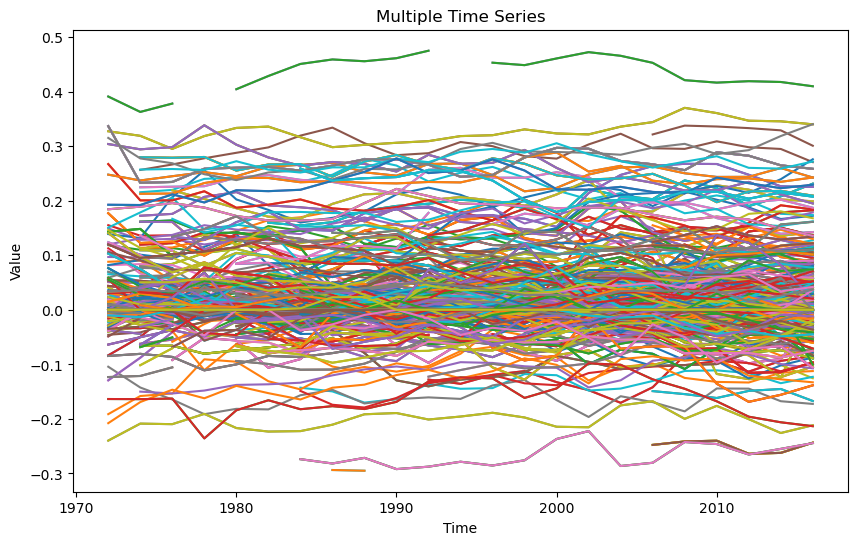

In [331]:
# Generate x-axis values (assuming time series are sampled at the same time points)
x_values = years
# what_to_plot = "weight_and_change"
# what_to_plot = "change"
what_to_plot = "weight"

# Plot each time series
plt.figure(figsize=(10, 6))
for i, (weight, change) in enumerate(zip(rows_of_edge_graph.T, rows_of_chng_graph.T)):
    # print(weight / np.nanmax(np.abs(weight)))
    # print(change / np.nanmax(np.abs(change)))
    if what_to_plot == "weight_and_change":
        plt.plot(x_values, weight / np.nanmax(np.abs(weight)), label=f'{edge_names[i]} val')
        plt.plot(x_values, change / np.nanmax(np.abs(change)), label=f'{edge_names[i]} change')
    elif what_to_plot == "change": 
        plt.plot(x_values, change, label=f'{edge_names[i]} change')
    elif what_to_plot == "weight":
        plt.plot(x_values, weight, label=f'{edge_names[i]} val')

# Add labels and title
# plt.yscale("log")
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Multiple Time Series')

if len(coordinates_to_draw[0]) < 5:
    plt.legend()

# Show the plot
plt.show()

In [336]:
start_year = 1972
change_start_year = 1975
end_year = 2018

for year in range(start_year, end_year, 2):
    relevant_row = years.index(year)

    path = f"../out/belief networks/{year}-{year + 4}, R=0.2, Condition=None"
    adj_mat, adj_var_list = get_sorted_adj_mat_and_var_list(path) 

    graph = networkx_graph_from_vars_adj_mat(adj_var_list, adj_mat)
    # net = display_graph_pyvis(graph, abs_val_edges=True)

    # graph = make_change_graph(adj_var_list, adj_mat, comp_var_list, change_data[relevant_row,:,:])
    # net = display_graph_pyvis(graph, abs_val_edges=True, remove_zero_edges=True, include_physics_buttons=True, equal_edge_weights=False, rank_edge_coloring=True)
    # net.show(os.path.join(path, "visual.html"))

    if year >= change_start_year:
        print("in here")
        graph = make_change_graph(adj_var_list, adj_mat, comp_var_list, change_data[relevant_row,:,:])
        net = display_graph_pyvis(graph, rank_edge_coloring=True, hi_fix_node="CONFED", lo_fix_node='SPKATH')
        net.show(os.path.join(path, f"change_visual_{year}.html"))

in here
../out/belief networks/1976-1980, R=0.2, Condition=None\change_visual_1976.html
in here
../out/belief networks/1978-1982, R=0.2, Condition=None\change_visual_1978.html
in here
../out/belief networks/1980-1984, R=0.2, Condition=None\change_visual_1980.html
in here
../out/belief networks/1982-1986, R=0.2, Condition=None\change_visual_1982.html
in here
../out/belief networks/1984-1988, R=0.2, Condition=None\change_visual_1984.html
in here
../out/belief networks/1986-1990, R=0.2, Condition=None\change_visual_1986.html
in here
../out/belief networks/1988-1992, R=0.2, Condition=None\change_visual_1988.html
in here
../out/belief networks/1990-1994, R=0.2, Condition=None\change_visual_1990.html
in here
../out/belief networks/1992-1996, R=0.2, Condition=None\change_visual_1992.html
in here
../out/belief networks/1994-1998, R=0.2, Condition=None\change_visual_1994.html
in here
../out/belief networks/1996-2000, R=0.2, Condition=None\change_visual_1996.html
in here
../out/belief networks/1

In [323]:
np.isnan(change_data).all(axis=(1, 2))

array([ True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [190]:
first_var = coordinates_to_draw[0][0]
second_var = coordinates_to_draw[1][0]

time_series = comp_data[:,first_var,second_var]
print(time_series)

first_var_name = comp_var_list[first_var]
second_var_name = comp_var_list[second_var]

edge_weights, years = make_edge_time_series_from_graph(1972, 2018, 4, 2, first_var_name, second_var_name)
print(edge_weights)


[        nan         nan         nan -0.00664461 -0.         -0.00468893
 -0.0034173  -0.00426588 -0.         -0.02008759 -0.04043922 -0.07570244
 -0.01179415 -0.         -0.02056662 -0.07169451 -0.0241432  -0.02820178
 -0.05883093 -0.04250546 -0.03439463 -0.04457498]
[None, None, None, -0.006644608761682035, 0, -0.004688931139800877, -0.0034173034826091935, -0.0042658814315643485, 0, -0.020087589769903748, -0.040439215036292574, -0.07570243683018119, -0.011794148079699484, 0, -0.02056662163008921, -0.07169450696666159, -0.024143200443090634, -0.028201782518775132, -0.058830925987165404, -0.04250545863313096, -0.03439463428140959, -0.04457498488383674]


In [5]:
# list 2 is a subset
lst1 = ["a", "b", "d", "d", "e", "f"]
lst2 = ["b", "d"]
exp_merge = ["a", "b", "d", "e", "f"]

exp_l1_inds = [0, 1, 2, 2, 3, 4]
exp_l2_inds = [1, 2]

merge_list, l1_inds, l2_inds = merge_sorted_lists(lst1, lst2)
assert merge_list == exp_merge
assert exp_l1_inds == l1_inds
assert exp_l2_inds == l2_inds

# completely disjoint
lst1 = ["a", "b", "c", "c"]
lst2 = ["d", "e", "f", "f"]
exp_merge = ["a", "b", "c", "d", "e", "f"]

exp_l1_inds = [0, 1, 2, 2]
exp_l2_inds = [3, 4, 5, 5]

merge_list, l1_inds, l2_inds = merge_sorted_lists(lst1, lst2)
assert merge_list == exp_merge
assert exp_l1_inds == l1_inds
assert exp_l2_inds == l2_inds

# finish list 1 first
lst1 = ["a", "b", "d"]
lst2 = ["b", "c", "e", "f", "g"]
exp_merge = list("abcdefg")

exp_l1_inds = [0, 1, 3]
exp_l2_inds = [1, 2, 4, 5, 6]

merge_list, l1_inds, l2_inds = merge_sorted_lists(lst1, lst2)
assert merge_list == exp_merge
assert exp_l1_inds == l1_inds
assert exp_l2_inds == l2_inds

# finish list 2 first
lst1 = list("abdeg")
lst2 = list("abc")
exp_merge = list("abcdeg")

exp_l1_inds = [0, 1, 3, 4, 5]
exp_l2_inds = [0, 1, 2]

merge_list, l1_inds, l2_inds = merge_sorted_lists(lst1, lst2)
assert merge_list == exp_merge
assert exp_l1_inds == l1_inds
assert exp_l2_inds == l2_inds

# add from list 2 and then get to an equal entry in list 1
lst1 = list("abcd")
lst2 = list("be")
exp_merge = list("abcde")

exp_l1_inds = [0, 1, 2, 3]
exp_l2_inds = [1, 4]

merge_list, l1_inds, l2_inds = merge_sorted_lists(lst1, lst2)
assert merge_list == exp_merge
assert exp_l1_inds == l1_inds
assert exp_l2_inds == l2_inds

# get to an equal entry at hte same time
lst1 = list("abcd")
lst2 = list("bbe")
exp_merge = list("abcde")

exp_l1_inds = [0, 1, 2, 3]
exp_l2_inds = [1, 1, 4]

merge_list, l1_inds, l2_inds = merge_sorted_lists(lst1, lst2)
assert merge_list == exp_merge
assert exp_l1_inds == l1_inds
assert exp_l2_inds == l2_inds

# add and then get multiple equal entries in both
lst1 = list("abbbcccd")
lst2 = list("bbee")
exp_merge = list("abcde")

exp_l1_inds = [0, 1, 1, 1, 2, 2, 2, 3]
exp_l2_inds = [1, 1, 4, 4]

merge_list, l1_inds, l2_inds = merge_sorted_lists(lst1, lst2)
assert merge_list == exp_merge
assert exp_l1_inds == l1_inds
assert exp_l2_inds == l2_inds

# multiple equal entries and list 2 finishes last
lst1 = list("abbbcccd")
lst2 = list("beefggh")
exp_merge = list("abcdefgh")

exp_l1_inds = [0, 1, 1, 1, 2, 2, 2, 3]
exp_l2_inds = [1, 4, 4, 5, 6, 6, 7]

merge_list, l1_inds, l2_inds = merge_sorted_lists(lst1, lst2)
assert merge_list == exp_merge
assert exp_l1_inds == l1_inds
assert exp_l2_inds == l2_inds

# multiple equal entries and list 1 finishes last
lst1 = list("abbbcccdijkkl")
lst2 = list("beefgghii")
exp_merge = list("abcdefghijkl")

exp_l1_inds = [0, 1, 1, 1, 2, 2, 2, 3, 8, 9, 10, 10, 11]
exp_l2_inds = [1, 4, 4, 5, 6, 6, 7, 8, 8]

merge_list, l1_inds, l2_inds = merge_sorted_lists(lst1, lst2)
assert merge_list == exp_merge
assert exp_l1_inds == l1_inds
assert exp_l2_inds == l2_inds

# repeats at the beginning
lst1 = list("abbbcccdijkkl")
lst2 = list("aabeefgghii")
exp_merge = list("abcdefghijkl")

exp_l1_inds = [0, 1, 1, 1, 2, 2, 2, 3, 8, 9, 10, 10, 11]
exp_l2_inds = [0, 0, 1, 4, 4, 5, 6, 6, 7, 8, 8]

merge_list, l1_inds, l2_inds = merge_sorted_lists(lst1, lst2)
assert merge_list == exp_merge
assert exp_l1_inds == l1_inds
assert exp_l2_inds == l2_inds

print(exp_l1_inds, l1_inds)
print(exp_l2_inds, l2_inds)

[0, 1, 1, 1, 2, 2, 2, 3, 8, 9, 10, 10, 11] [0, 1, 1, 1, 2, 2, 2, 3, 8, 9, 10, 10, 11]
[0, 0, 1, 4, 4, 5, 6, 6, 7, 8, 8] [0, 0, 1, 4, 4, 5, 6, 6, 7, 8, 8]


In [ ]:
variables_test_1 = ["apple", "balfour", "danube", "epcot", "gobbledygook"]
variables_test_2 = ["apple", "cobra", "epcot", "fantasia", "hedonic"]

var_arr_1 = np.arange(25).reshape(1, 5, 5)
var_arr_2 = np.arange(25, 50).reshape(1, 5, 5)

exp_merge = np.array([[[0, 1, np.nan, 2, 3, np.nan, 4, np.nan],
                       [5, 6, np.nan, 7, 8, np.nan, 9, np.nan],
                       [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                       [10, 11, np.nan, 12, 13, np.nan, 14, np.nan],
                       [15, 16, np.nan, 17, 18, np.nan, 19, np.nan],
                       [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                       [20, 21, np.nan, 22, 23, np.nan, 24, np.nan],
                       [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]],
                      [[25, np.nan, 26, np.nan, 27, 28, np.nan, 29],
                       [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                       [30, np.nan, 31, np.nan, 32, 33, np.nan, 34], 
                       [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                       [35, np.nan, 36, np.nan, 37, 38, np.nan, 39], 
                       [40, np.nan, 41, np.nan, 42, 43, np.nan, 44],
                       [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                       [45, np.nan, 46, np.nan, 47, 48, np.nan, 49]]])

var_list, var_mat = combine_variable_matrix_stacks(variables_test_1, variables_test_2, var_arr_1, var_arr_2)
assert ((var_mat == exp_merge) | (np.isnan(var_mat) & np.isnan(exp_merge))).all()

In [ ]:
variables_test_1 = ["ant", "bee", "dog"]
variables_test_2 = ["ant", "cat", "dog"]

var_arr_1 = np.array([[[1, 2, 4],
                       [2, 4, 8],
                       [4, 8, 16]],
                      [[0.5, 1, 2],
                       [1, 2, 4],
                       [2, 4, 8]]])

var_arr_2 = np.array([[[1, 3, 4],
                       [3, 9, 12],
                       [4, 12, 16]]])

exp_merge = np.array([[[1, 2, np.nan, 4],
                       [2, 4, np.nan, 8],
                       [np.nan, np.nan, np.nan, np.nan],
                       [4, 8, np.nan, 16]],
                      [[0.5, 1, np.nan, 2],
                       [1, 2, np.nan, 4],
                       [np.nan, np.nan, np.nan, np.nan],
                       [2, 4, np.nan, 8]],
                      [[1, np.nan, 3, 4],
                       [np.nan, np.nan, np.nan, np.nan],
                       [3, np.nan, 9, 12],
                       [4, np.nan, 12, 16]]])

var_list, var_mat = combine_variable_matrix_stacks(variables_test_1, variables_test_2, var_arr_1, var_arr_2)

assert var_list == ["ant", "bee", "cat", "dog"]
assert ((var_mat == exp_merge) | (np.isnan(var_mat) & np.isnan(exp_merge))).all()

In [272]:
shuffled_var_list = ["cat", "dog", "frog"]
var_list = ["dog", "frog", "hello", "cat", "baker"]

mat = np.arange(25).reshape(5, 5)

new_mat = make_consistent_matrix(shuffled_var_list, var_list, mat)

exp_new_mat = np.array([[18, 15, 16],
                        [3, 0, 1],
                        [8, 5, 6]])

assert (exp_new_mat == new_mat).all()


[3, 0, 1]


In [17]:
before_graph = nx.read_graphml("../out/belief networks/2012-2016, R=0.2, Condition=None/graph_object.graphml")
after_graph = nx.read_graphml("../out/belief networks/2014-2018, R=0.2, Condition=None/graph_object.graphml")

print([d for i, (u, v, d) in enumerate(before_graph.edges(data=True)) if i < 10])


merged_graph = merge_graphs_with_weight_diff(before_graph, after_graph, pct_change=False)

net = display_graph_pyvis(merged_graph, equal_edge_weights=False)
net.show("graph.html")

[{'weight': 0.1311082764930741}, {'weight': 0.029541663554264703}, {'weight': -0.03439463428140959}, {'weight': 0.019616557257829566}, {'weight': -0.007338891283974845}, {'weight': -0.023375322702839808}, {'weight': 0.41921445292477727}, {'weight': 0.02657307661023439}, {'weight': -0.03187243668731505}, {'weight': -0.05909564115126111}]
{'type': -0.0014565635023631729, 'width': 8.355157788448281, 'from': 'PARTYID', 'to': 'PRESLAST_DEMREP', 'color': '#f5f7f2'}
{'type': 0.004617070099174757, 'width': 0.09234140198349514, 'from': 'GRASS', 'to': 'ABNOMORE', 'color': '#faedf3'}
{'type': -0.02587859856260849, 'width': 0.5175719712521698, 'from': 'HOMOSEX', 'to': 'CONSCI', 'color': '#9ccf64'}
{'type': -0.02604321732742776, 'width': 3.7655509300905288, 'from': 'SPKCOM', 'to': 'COLCOM', 'color': '#9ccf64'}
graph.html


In [20]:
# test 

G1 = nx.Graph()
G1.add_edge("zero", "one", weight=2)
G1.add_edge("one", "two", weight=4)
G1.add_edge("two", "three", weight=6)

G2 = nx.Graph()
G2.add_edge("two", "three", weight=5)
G2.add_edge("three", "four", weight=7)
G2.add_edge("four", "five", weight=9)

# Merge the graphs
merged_G = merge_graphs_with_weight_diff(G1, G2)

# Print edges with weights of the merged graph
for u, v, data in merged_G.edges(data=True):
    print(f"({u}, {v}) - weight: {data['weight']}")

for u, v, data in merged_G.edges(data=True):
    print(f"({u}, {v}) - type: {data['type']}")

(zero, one) - weight: 2
(one, two) - weight: 4
(two, three) - weight: 6
(three, four) - weight: 0
(four, five) - weight: 0
(zero, one) - type: 2
(one, two) - type: 4
(two, three) - type: 1
(three, four) - type: -7
(four, five) - type: -9


In [21]:
from pyvis.network import Network

net = Network('1000px', '1000px', notebook=True, cdn_resources='remote')

for e in net.edges:
    print(e["type"])


print([d for u, v, d in merged_G.edges(data=True)])


[{'weight': 2, 'type': 2}, {'weight': 4, 'type': 4}, {'weight': 6, 'type': 1}, {'weight': 0, 'type': -7}, {'weight': 0, 'type': -9}]
graph.html
